# Logistic distribution simulation

In [1]:
library(evd)
library(maxstablePCA)
library(ggplot2)
library(dplyr)
library(GGally)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data 

In [2]:
set.seed(180424)
s <- 100

In [3]:
X1 <- rmvevd(10000, dep = .2, model = "log", d = 5)
X2 <- rmvevd(10000, dep = .5, model = "log", d = 5)
X3 <- rmvevd(10000, dep = .8, model = "log", d = 5)

In [4]:
X1trafo <- transform_unitpareto(X1)
X2trafo <- transform_unitpareto(X2)
X3trafo <- transform_unitpareto(X3)

# max-stable PCA for X1

In [5]:
summary(apply(X1trafo, 1, max))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    1.004     1.577     2.545    13.033     5.274 10000.000 

In [6]:
length(which(apply(X1trafo, 1, max) > s))

[1] 138

In [7]:
maxPCAX1P1 <- max_stable_prcomp(X1trafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P2 <- max_stable_prcomp(X1trafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P3 <- max_stable_prcomp(X1trafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P4 <- max_stable_prcomp(X1trafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [8]:
maxPCAX1P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
          [,1]      [,2]      [,3]
[1,] 1.2259495 0.3386254 0.2152784
[2,] 0.1905930 0.1778669 1.0835299
[3,] 0.3598006 1.0707083 0.7151039
[4,] 0.9158107 0.8390863 0.8772472
[5,] 0.1945241 1.1827976 0.3494505

$encoder_matrix
          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 0.8156917 0.1346598 0.1796936 0.2370620 0.1445028
[2,] 0.1322362 0.2167687 0.4218422 0.1118411 0.8454534
[3,] 0.1140770 0.9229008 0.1240546 0.2153098 0.1799514

$reconstr_matrix
          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 0.9999968 0.1986806 0.2202952 0.2906261 0.2862920
[2,] 0.1554651 0.9999906 0.1344169 0.2332946 0.1949827
[3,] 0.2934863 0.6599700 0.4516700 0.1539689 0.9052340
[4,] 0.7470192 0.8096121 0.3539621 0.2171039 0.7094084
[5,] 0.1586717 0.3225082 0.4989540 0.1322854 1.0000003

$loss_fctn_value
[1] 0.5676394

$optim_conv_status
[1] 4

$s
[1] 100

$starting_vals
$starting_vals$decoder_matrix_x0
          [,1]      [,2]      [,3]
[1,] 1.0000000 

In [9]:
estimate_dist <- function(maxpca, n, d, encoded_extr_data) {
    result <- maxpca$loss_fctn_value 
    getxstar <- function(A, b) {
        res <- rep(0, maxpca$p)
        for(j in 1:(maxpca$p)){
            res[j] <- min(b / A[,j])
        } 
        return(res)
    }
                                    
    # determine relevant indices that form basis 
    rowmax <- apply(maxpca$encoder_matrix, 1, max)
    inds <- c()
    for(i in 1:maxpca$p) {
        inds <- c(inds, which(maxpca$encoder_matrix[i,] == rowmax[i])) 
    }
                  
    datinds <- 1:d
    notactiveinds <- datinds[which(!(datinds %in% inds))]
                  
    residmat <- matrix(NA, d - maxpca$p, maxpca$p)
    
    ind <- 1
    for(i in notactiveinds) {
        tmpxstar <- getxstar(maxpca$decoder_matrix[inds, ], maxpca$decoder_matrix[i,])
        tmpapprox <- maxmatmul(maxpca$decoder_matrix[inds,], tmpxstar)
        residmat[ind,] <- maxpca$decoder_matrix[i,] - tmpapprox
        ind <- ind + 1
    }
    if(maxpca$p == 2) return(result)
    
    end <- apply(encoded_extr_data, 1, function(z) z / sum(z))
    return(result + maxpca$s / n * sum(maxmatmul(residmat, end)))
}

In [10]:
estimate_dist(maxPCAX1P3, 10000, 5, t(maxmatmul(maxPCAX1P3$encoder_matrix, t(X1trafo)))[which(rowSums(X1trafo) > s), ])

[1] 0.5676394

In [11]:
round(maxPCAX1P3$decoder_matrix, 2)

1.23,0.34,0.22
0.19,0.18,1.08
0.36,1.07,0.72
0.92,0.84,0.88
0.19,1.18,0.35


In [12]:
round(maxPCAX1P3$encoder_matrix, 2)

0.82,0.13,0.18,0.24,0.14
0.13,0.22,0.42,0.11,0.85
0.11,0.92,0.12,0.22,0.18


In [13]:
round(maxPCAX1P3$reconstr_matrix, 2)

1.00,0.20,0.22,0.29,0.29
0.16,1.00,0.13,0.23,0.19
0.29,0.66,0.45,0.15,0.91
0.75,0.81,0.35,0.22,0.71
0.16,0.32,0.50,0.13,1.00


#### rescale the matrices such that the largest rowwise entries of $\hat W$ are equal to one

In [14]:
round(maxmatmul(maxPCAX1P3$decoder_matrix, diag(apply(maxPCAX1P3$encoder_matrix, 1, max))), 2)

1.00,0.29,0.20
0.16,0.15,1.00
0.29,0.91,0.66
0.75,0.71,0.81
0.16,1.00,0.32


In [15]:
round(t(apply(maxPCAX1P3$encoder_matrix, 1, function(z) z / max(z))), 2)

1.00,0.17,0.22,0.29,0.18
0.16,0.26,0.50,0.13,1.00
0.12,1.00,0.13,0.23,0.19


In [16]:
maxPCAX1P1$loss_fctn_value

[1] 1.11329

### elbow plot and pairplot to visually inspect fit

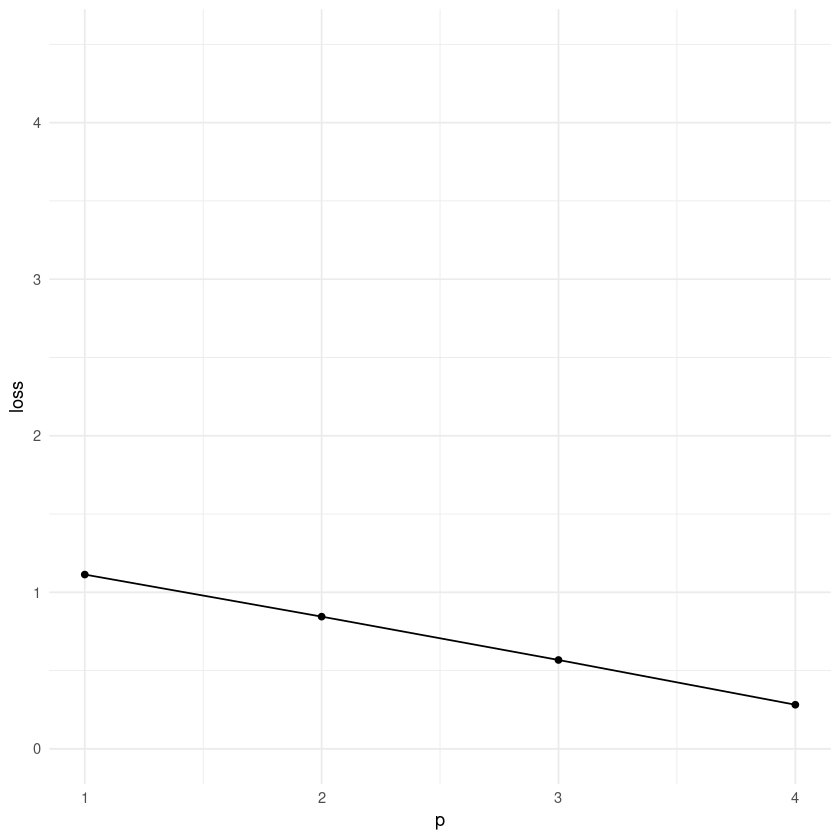

In [17]:
plotlossdatX1 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX1P1$loss_fctn_value, 
        maxPCAX1P2$loss_fctn_value, 
        maxPCAX1P3$loss_fctn_value, 
        maxPCAX1P4$loss_fctn_value

    )
)

pe1 <- ggplot(aes(x = p, y = loss), data = plotlossdatX1) + geom_line() + geom_point() + ylim(0,4.5) + theme_minimal()
pe1

In [18]:
ggsave("logistic_dephigh_elbow.pdf", pe1)

Saving 6.67 x 6.67 in image


In [19]:
rec1 <- t(maxmatmul(maxPCAX1P3$reconstr_matrix, t(exp(X1))))

In [20]:
datX1 <- data.frame(exp(X1))
datX1$is_rec = "original"
datrec1 <- data.frame(rec1)
datrec1$is_rec = "reconstruction"
names(datrec1) <- names(datX1)
plot_datX1 <- full_join(datX1, datrec1)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


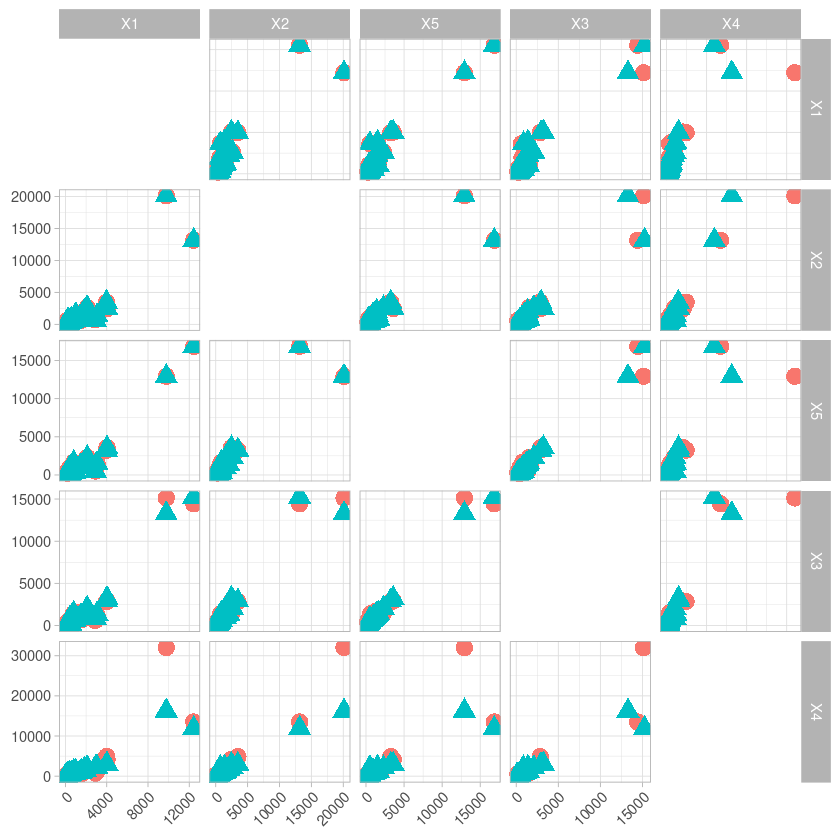

In [21]:
p1 <- ggpairs(
    plot_datX1, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = c(1,2,5,3,4),
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p1

In [22]:
ggsave("logistic_dephigh.png", p1)

Saving 6.67 x 6.67 in image


# Max-stable PCA for X2

In [23]:
length(which(apply(X2trafo, 1, max) > s))

[1] 225

In [24]:
maxPCAX2P1 <- max_stable_prcomp(X2trafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P2 <- max_stable_prcomp(X2trafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P3 <- max_stable_prcomp(X2trafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P4 <- max_stable_prcomp(X2trafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [25]:
maxPCAX2P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
            [,1]        [,2]        [,3]
[1,] 0.006375097 0.004294031 1.053848949
[2,] 1.328524274 0.001141440 0.009084926
[3,] 0.529617440 0.237286564 0.580449861
[4,] 0.637281037 0.441794716 0.109611892
[5,] 0.007993694 1.706266172 0.004486715

$encoder_matrix
            [,1]        [,2]        [,3]        [,4]        [,5]
[1,] 0.002140774 0.752668786 0.011547330 0.003068910 0.004617031
[2,] 0.004973648 0.003689665 0.004317807 0.005696903 0.586070264
[3,] 0.948906123 0.002333537 0.011467566 0.008919177 0.001351900

$reconstr_matrix
            [,1]        [,2]        [,3]        [,4]        [,5]
[1,] 1.000003721 0.004798336 0.012085083 0.009399466 0.002516604
[2,] 0.008620742 0.999938753 0.015340908 0.004077122 0.006133838
[3,] 0.550792428 0.398626516 0.006656347 0.005177135 0.139066599
[4,] 0.104011396 0.479661545 0.007358895 0.002516862 0.258922745
[5,] 0.008486367 0.006295550 0.007367328 0.009720433 0.999991865

$loss_fctn_value
[1] 1.462209

$

In [26]:
estimate_dist(maxPCAX2P3, 10000, 5, t(maxmatmul(maxPCAX2P3$encoder_matrix, t(X2trafo)))[which(rowSums(X2trafo) > s), ])

[1] 1.462209

In [27]:
round(maxPCAX2P3$decoder_matrix, 2)

0.01,0.00,1.05
1.33,0.00,0.01
0.53,0.24,0.58
0.64,0.44,0.11
0.01,1.71,0.00


In [28]:
round(maxPCAX2P3$encoder_matrix, 2)

0.00,0.75,0.01,0.00,0.00
0.00,0.00,0.00,0.01,0.59
0.95,0.00,0.01,0.01,0.00


In [29]:
round(maxPCAX2P3$reconstr_matrix, 2)

1.00,0.00,0.01,0.01,0.00
0.01,1.00,0.02,0.00,0.01
0.55,0.40,0.01,0.01,0.14
0.10,0.48,0.01,0.00,0.26
0.01,0.01,0.01,0.01,1.00


#### rescale the matrices such that the largest rowwise entries of $\hat W$ are equal to one

In [30]:
round(maxmatmul(maxPCAX2P3$decoder_matrix, diag(apply(maxPCAX2P3$encoder_matrix, 1, max))), 2)

0.00,0.00,1.00
1.00,0.00,0.01
0.40,0.14,0.55
0.48,0.26,0.10
0.01,1.00,0.00


In [31]:
round(t(apply(maxPCAX2P3$encoder_matrix, 1, function(z) z / max(z))), 2)

0.00,1.00,0.02,0.00,0.01
0.01,0.01,0.01,0.01,1.00
1.00,0.00,0.01,0.01,0.00


### elbow plot and pairplot to visually inspect fit

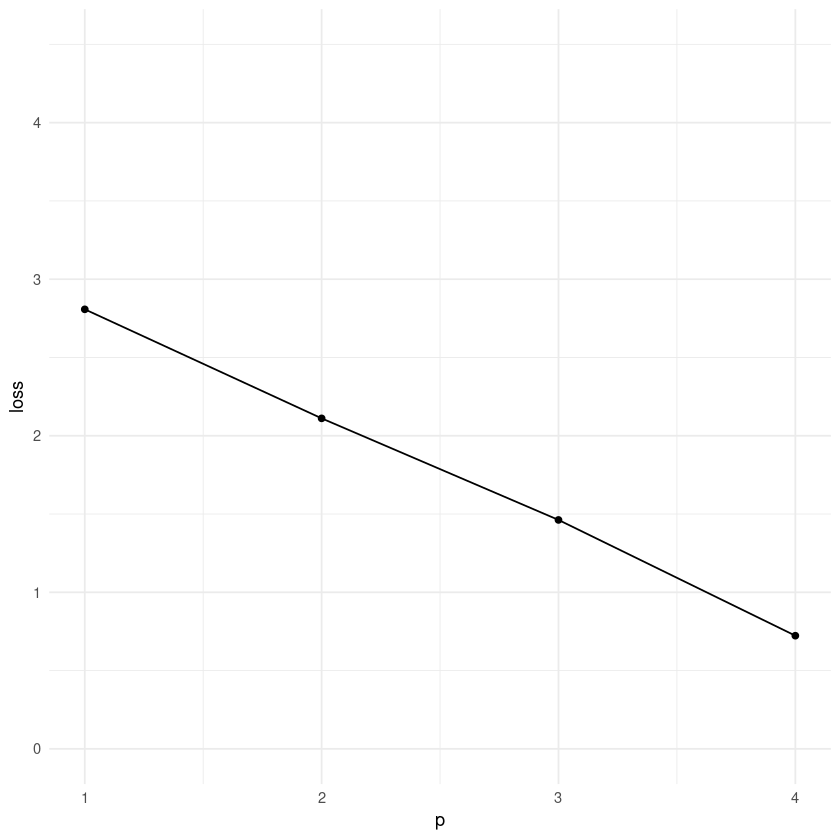

In [32]:
plotlossdatX2 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX2P1$loss_fctn_value,
        maxPCAX2P2$loss_fctn_value,
        maxPCAX2P3$loss_fctn_value,
        maxPCAX2P4$loss_fctn_value

    )
)

pe2 <- ggplot(aes(x = p, y = loss),  data = plotlossdatX2) + geom_line() + geom_point() + ylim(0,4.5) + theme_minimal()
pe2

In [33]:
ggsave("logistic_depmed_elbow.pdf", pe2)

Saving 6.67 x 6.67 in image


In [34]:
rec2 <- t(maxmatmul(maxPCAX2P3$reconstr_matrix, t(exp(X2))))

In [35]:
datX2 <- data.frame(exp(X2))
datX2$is_rec = "original"
datrec2 <- data.frame(rec2)
datrec2$is_rec = "reconstruction"
names(datrec2) <- names(datX2)
plot_datX2 <- full_join(datX2, datrec2)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


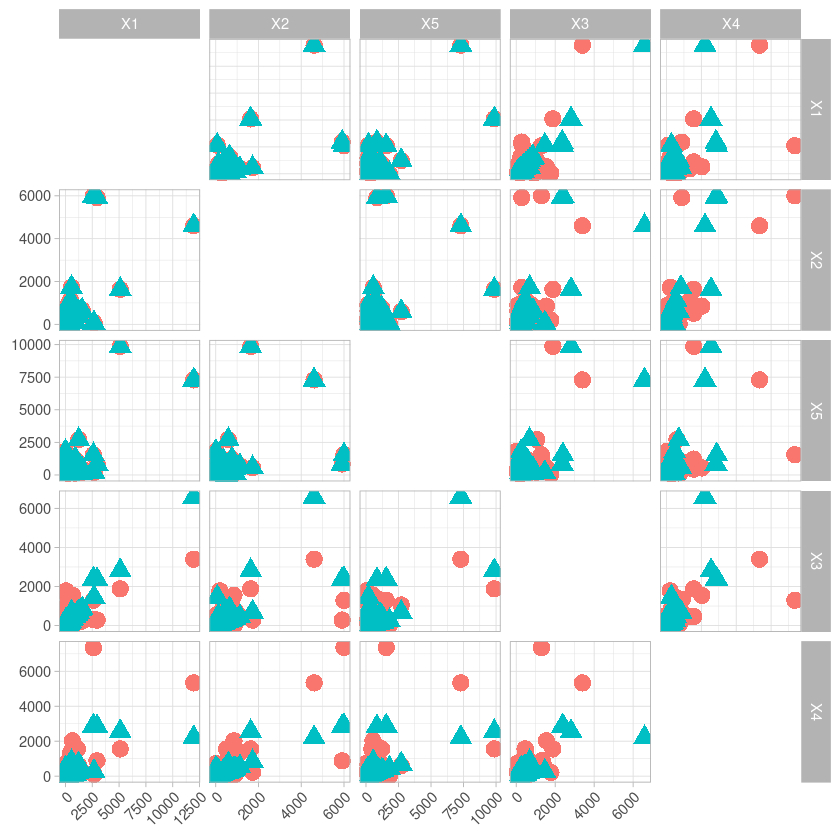

In [36]:
p2 <- ggpairs(
    plot_datX2, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = c(1,2,5,3,4),
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p2

In [37]:
ggsave("logistic_depmed.png", p2)

Saving 6.67 x 6.67 in image


# Same for X3

In [38]:
length(which(apply(X3trafo, 1, max) > s))

[1] 356

In [39]:
maxPCAX3P1 <- max_stable_prcomp(X3trafo, p = 1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX3P2 <- max_stable_prcomp(X3trafo, p = 2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX3P3 <- max_stable_prcomp(X3trafo, p = 3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX3P4 <- max_stable_prcomp(X3trafo, p = 4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [40]:
maxPCAX3P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
            [,1]         [,2]        [,3]
[1,] 0.150401953 1.258429e-01 0.018583221
[2,] 1.669277362 4.786831e-18 0.003977001
[3,] 0.133365348 8.941051e-02 0.028091746
[4,] 0.002260317 1.451681e+00 0.003320241
[5,] 0.002445769 1.035458e-03 1.498590566

$encoder_matrix
             [,1]         [,2]         [,3]         [,4]         [,5]
[1,] 0.0014703304 5.990663e-01 0.0033174138 0.0004346622 0.0002790334
[2,] 0.0001808305 8.029398e-18 0.0012500828 0.6888572700 0.0013243908
[3,] 0.0004984025 2.975040e-03 0.0007078408 0.0029820324 0.6674832248

$reconstr_matrix
             [,1]        [,2]         [,3]         [,4]        [,5]
[1,] 0.0002211406 0.090100747 0.0004989455 0.0866878159 0.012403989
[2,] 0.0024543892 1.000007872 0.0055376837 0.0007255718 0.002654581
[3,] 0.0001960911 0.079894690 0.0004424280 0.0615910786 0.018750769
[4,] 0.0002625081 0.001354080 0.0018147211 1.0000008171 0.002216205
[5,] 0.0007469012 0.004458367 0.0010607635 0.0044688457 1

In [41]:
estimate_dist(maxPCAX3P3, 10000, 5, t(maxmatmul(maxPCAX3P3$encoder_matrix, t(X3trafo)))[which(rowSums(X3trafo) > s), ])

[1] 2.001434

In [42]:
round(maxPCAX3P3$decoder_matrix, 2)

0.15,0.13,0.02
1.67,0.00,0.00
0.13,0.09,0.03
0.00,1.45,0.00
0.00,0.00,1.50


In [43]:
round(maxPCAX3P3$encoder_matrix, 2)

0,0.6,0,0.00,0.00
0,0.0,0,0.69,0.00
0,0.0,0,0.00,0.67


In [44]:
round(maxPCAX3P3$reconstr_matrix, 2)

0,0.09,0.00,0.09,0.01
0,1.00,0.01,0.00,0.00
0,0.08,0.00,0.06,0.02
0,0.00,0.00,1.00,0.00
0,0.00,0.00,0.00,1.00


#### rescale the matrices such that the largest rowwise entries of $\hat W$ are equal to one

In [45]:
round(maxmatmul(maxPCAX3P3$decoder_matrix, diag(apply(maxPCAX3P3$encoder_matrix, 1, max))), 2)

0.09,0.09,0.01
1.00,0.00,0.00
0.08,0.06,0.02
0.00,1.00,0.00
0.00,0.00,1.00


In [46]:
round(t(apply(maxPCAX3P3$encoder_matrix, 1, function(z) z / max(z))), 2)

0,1,0.01,0,0
0,0,0.00,1,0
0,0,0.00,0,1


### elbow plot and pairplot to visually inspect fit

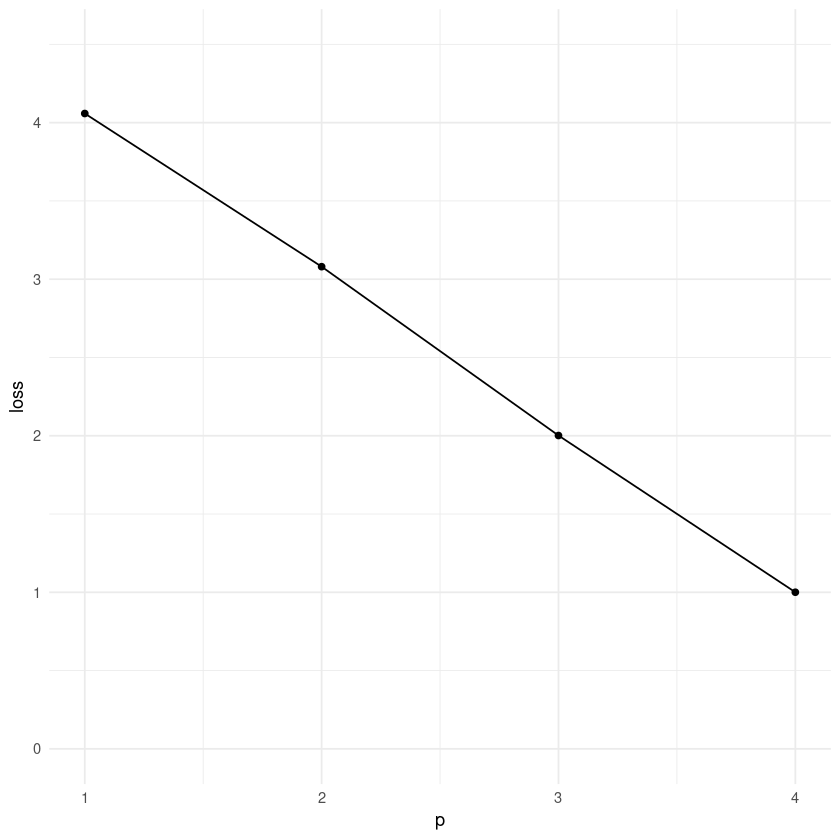

In [47]:
plotlossdatX3 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX3P1$loss_fctn_value,
        maxPCAX3P2$loss_fctn_value,
        maxPCAX3P3$loss_fctn_value,
        maxPCAX3P4$loss_fctn_value

    )
)

pe3 <- ggplot(aes(x = p, y = loss),  data = plotlossdatX3) + geom_line() + geom_point() + ylim(0,4.5) + theme_minimal()
pe3

In [48]:
ggsave("logistic_deplow_elbow.pdf", pe3)

Saving 6.67 x 6.67 in image


In [49]:
rec3 <- t(maxmatmul(maxPCAX3P3$reconstr_matrix, t(exp(X3))))

In [50]:
datX3 <- data.frame(exp(X3))
datX3$is_rec = "original"
datrec3 <- data.frame(rec3)
datrec3$is_rec = "reconstruction"
names(datrec3) <- names(datX3)
plot_datX3 <- full_join(datX3, datrec3)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


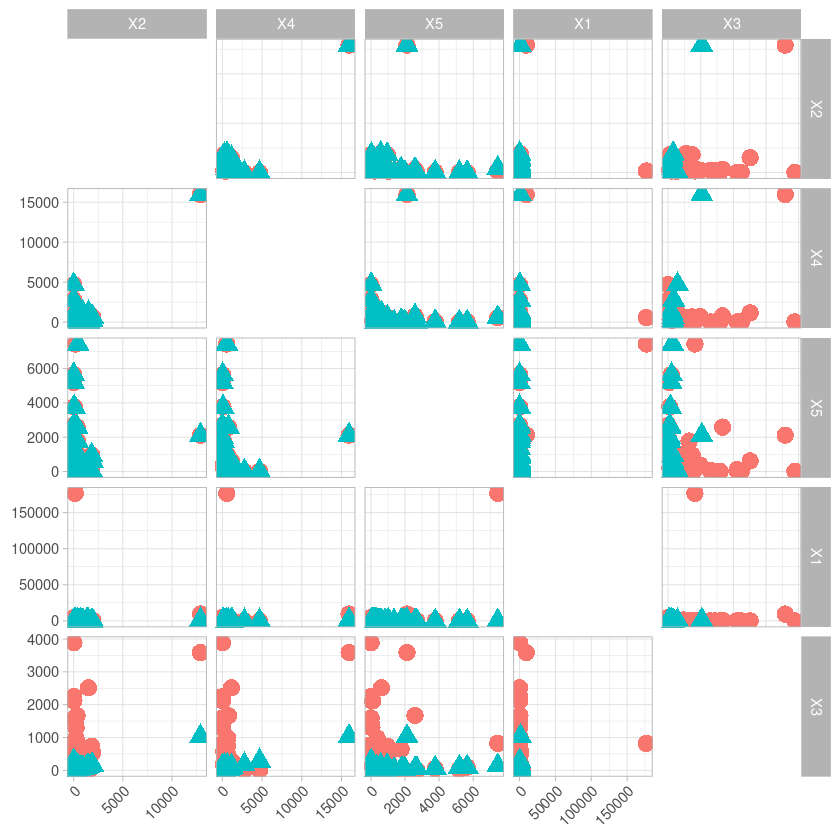

In [51]:
p3 <- ggpairs(
    plot_datX3, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = c(2,4,5,1,3),
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p3

In [52]:
ggsave("logistic_deplow.png", p3)

Saving 6.67 x 6.67 in image


# Comparison to other methods

### PCA for extremes as in Drees/Saubourin

In [53]:
Xsphere1 <- t(apply(X1trafo, 1, function(z) z / max(z)))
Xsphere1 <- Xsphere1[which(apply(X1trafo, 1, max) > 100), ]
                    
Xsphere2 <- t(apply(X2trafo, 1, function(z) z / max(z)))
Xsphere2 <- Xsphere2[which(apply(X2trafo, 1, max) > 100), ]   

Xsphere3 <- t(apply(X3trafo, 1, function(z) z / max(z)))
Xsphere3 <- Xsphere3[which(apply(X3trafo, 1, max) > 100), ]  

In [54]:
specdecomp1 <- eigen(t(Xsphere1) %*% Xsphere1 / 40)
specdecomp1

eigen() decomposition
$values
[1] 9.4137796 0.1665035 0.1438496 0.1190644 0.1047458

$vectors
           [,1]        [,2]       [,3]        [,4]        [,5]
[1,] -0.4441700  0.86051076 -0.1206433 -0.21788930  0.01427197
[2,] -0.4508374 -0.09591986 -0.1958854  0.60835232 -0.61569583
[3,] -0.4462404 -0.43832559 -0.2316505 -0.70828817 -0.23109753
[4,] -0.4467027 -0.21857490 -0.3368276  0.28287083  0.74780545
[5,] -0.4480902 -0.10206030  0.8831531  0.02727025  0.08997722


In [55]:
specdecomp2 <- eigen(t(Xsphere2) %*% Xsphere2 / 40)
specdecomp2

eigen() decomposition
$values
[1] 6.0645530 0.8384639 0.6717965 0.6343140 0.6150610

$vectors
           [,1]       [,2]       [,3]       [,4]       [,5]
[1,] -0.4535468 -0.4195804 -0.3840985 -0.4431559  0.5237641
[2,] -0.4503430 -0.1426556  0.5289313  0.5913156  0.3839507
[3,] -0.4625304 -0.1749351  0.4762744 -0.4493522 -0.5715843
[4,] -0.4417272  0.8715257 -0.0802449 -0.1427238  0.1360543
[5,] -0.4271174 -0.1159412 -0.5826007  0.4813223 -0.4827356


In [56]:
specdecomp3 <- eigen(t(Xsphere3) %*% Xsphere3 / 40)
specdecomp3

eigen() decomposition
$values
[1] 4.600568 1.612153 1.534150 1.507838 1.415797

$vectors
          [,1]       [,2]         [,3]        [,4]        [,5]
[1,] 0.4336408  0.4315091  0.185311932  0.49007864 -0.59265334
[2,] 0.4266268  0.5941795 -0.259254316 -0.04164399  0.62927999
[3,] 0.4415958 -0.2400051 -0.678935594 -0.37930323 -0.37757945
[4,] 0.4937870 -0.1268834  0.661384802 -0.54972560  0.02113977
[5,] 0.4371645 -0.6221325  0.007955592  0.55858708  0.33129381


Joining with `by = join_by(X1, X2, X3, X4, X5)`


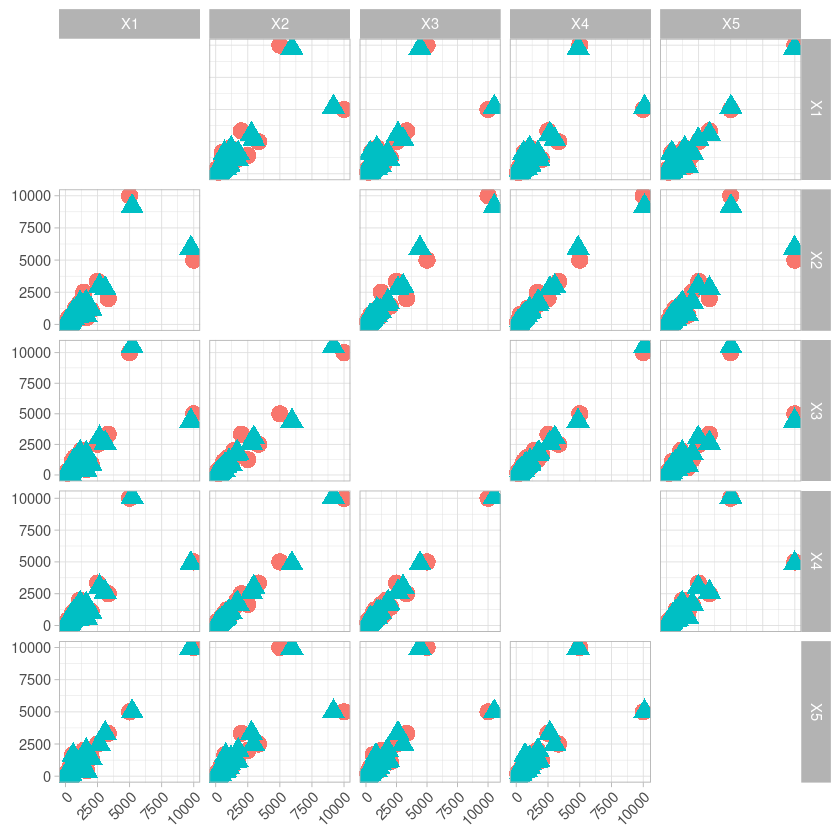

In [57]:
rec1 <- X1trafo %*% specdecomp1$vectors[1:5, 1:3] %*% t(specdecomp1$vectors[1:5, 1:3])

plotdat_DS1 <- data.frame(X1trafo)
tmp <- data.frame(rec1)
plotdat_DS1 <- full_join(plotdat_DS1, tmp)
plotdat_DS1$is_rec <- c(rep(F, 10000), rep(T, 10000))

ggpairs(plotdat_DS1,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Joining with `by = join_by(X1, X2, X3, X4, X5)`


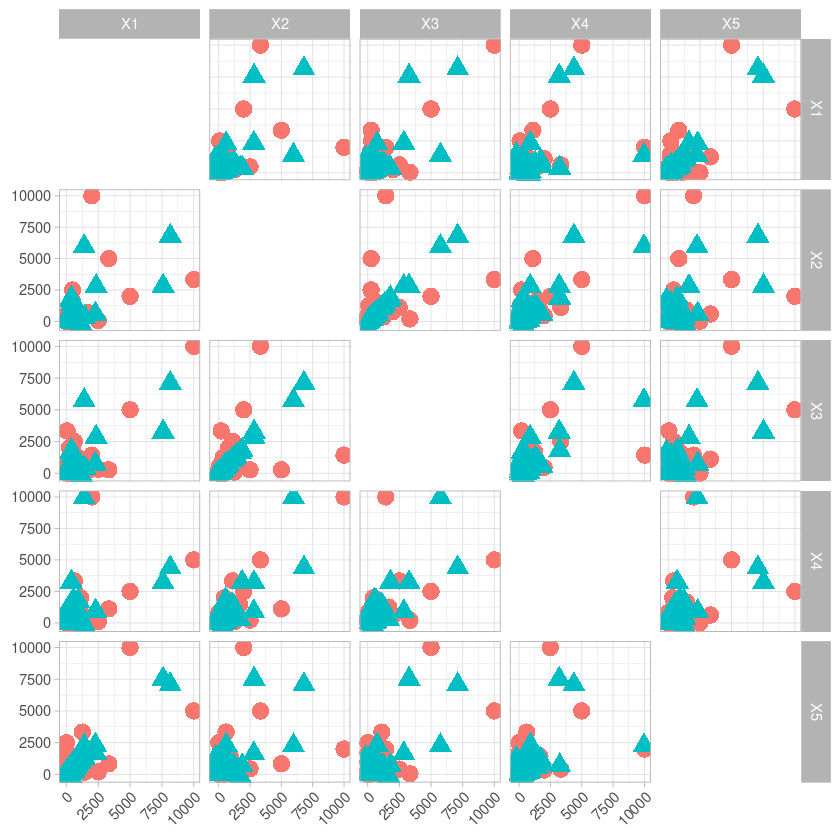

In [58]:
rec2 <- X2trafo %*% specdecomp2$vectors[1:5, 1:3] %*% t(specdecomp2$vectors[1:5, 1:3])

plotdat_DS2 <- data.frame(X2trafo)
tmp <- data.frame(rec2)
plotdat_DS2 <- full_join(plotdat_DS2, tmp)
plotdat_DS2$is_rec <- c(rep(F, 10000), rep(T, 10000))

ggpairs(plotdat_DS2,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Joining with `by = join_by(X1, X2, X3, X4, X5)`


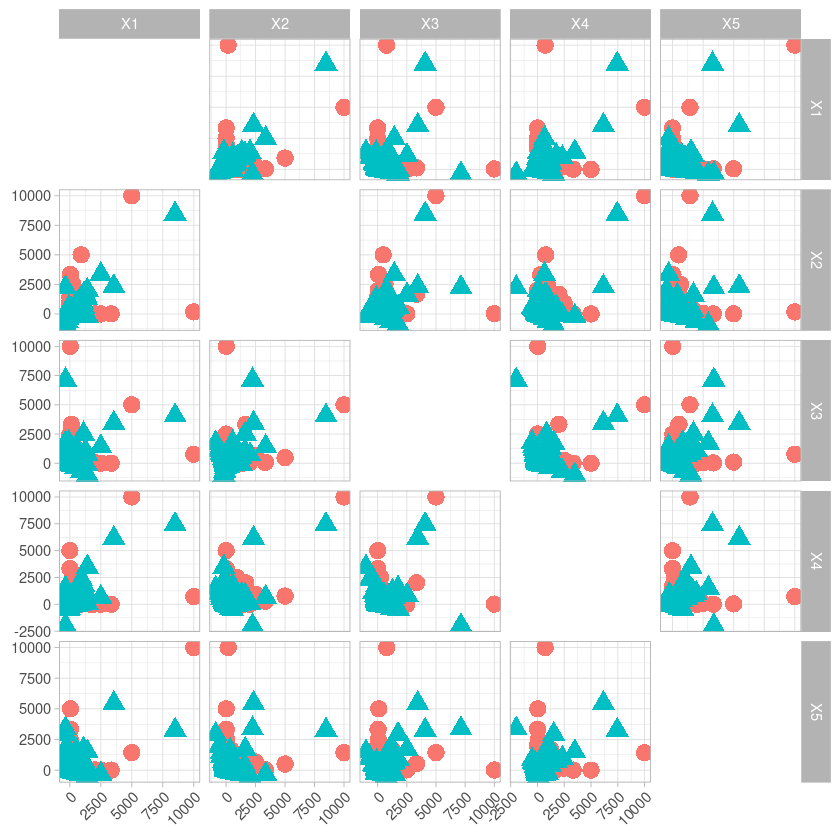

In [59]:
rec3 <- X3trafo %*% specdecomp3$vectors[1:5, 1:3] %*% t(specdecomp3$vectors[1:5, 1:3])

plotdat_DS3 <- data.frame(X3trafo)
tmp <- data.frame(rec3)
plotdat_DS3 <- full_join(plotdat_DS3, tmp)
plotdat_DS3$is_rec <- c(rep(F, 10000), rep(T, 10000))

ggpairs(plotdat_DS3,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

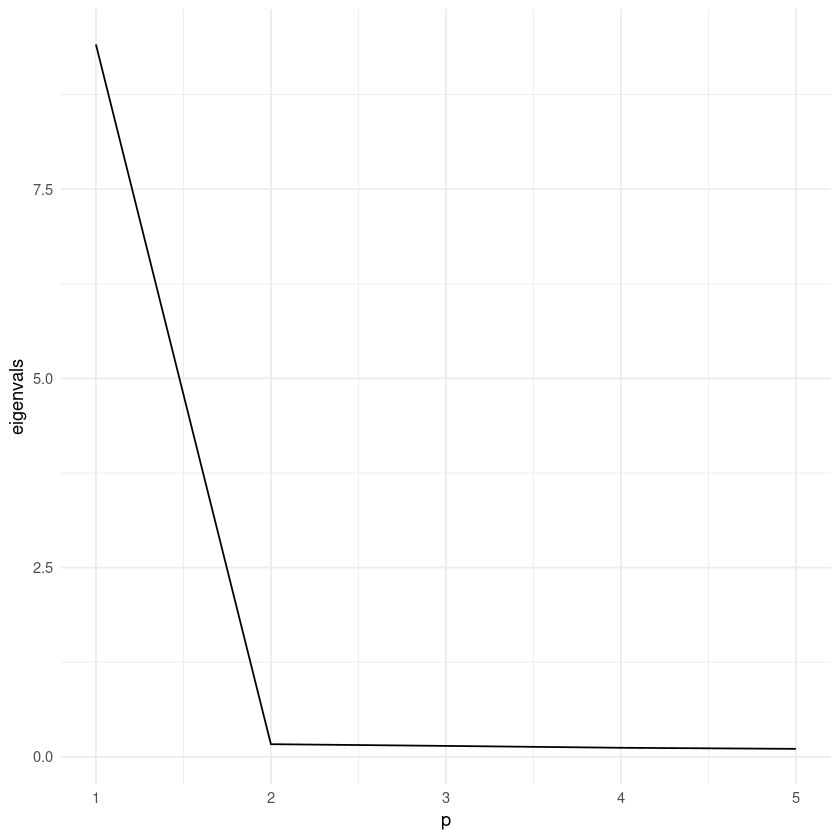

In [60]:
screeplotdat1 <- data.frame(p = 1:5, eigenvals = specdecomp1$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat1) + 
geom_line() + 
theme_minimal()

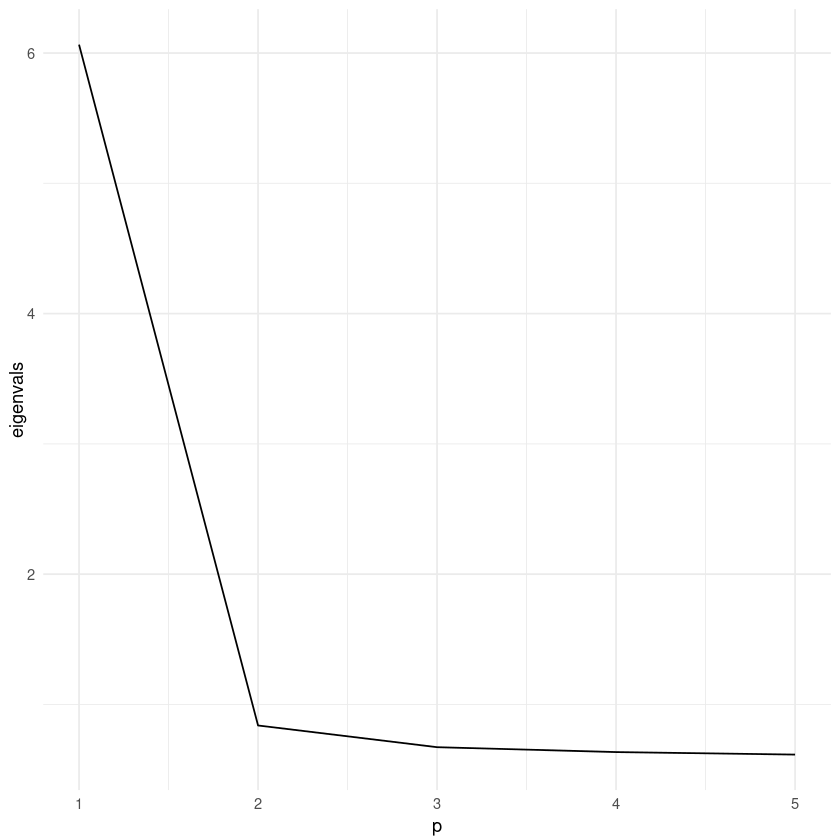

In [61]:
screeplotdat2 <- data.frame(p = 1:5, eigenvals = specdecomp2$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat2) + 
geom_line() + 
theme_minimal()

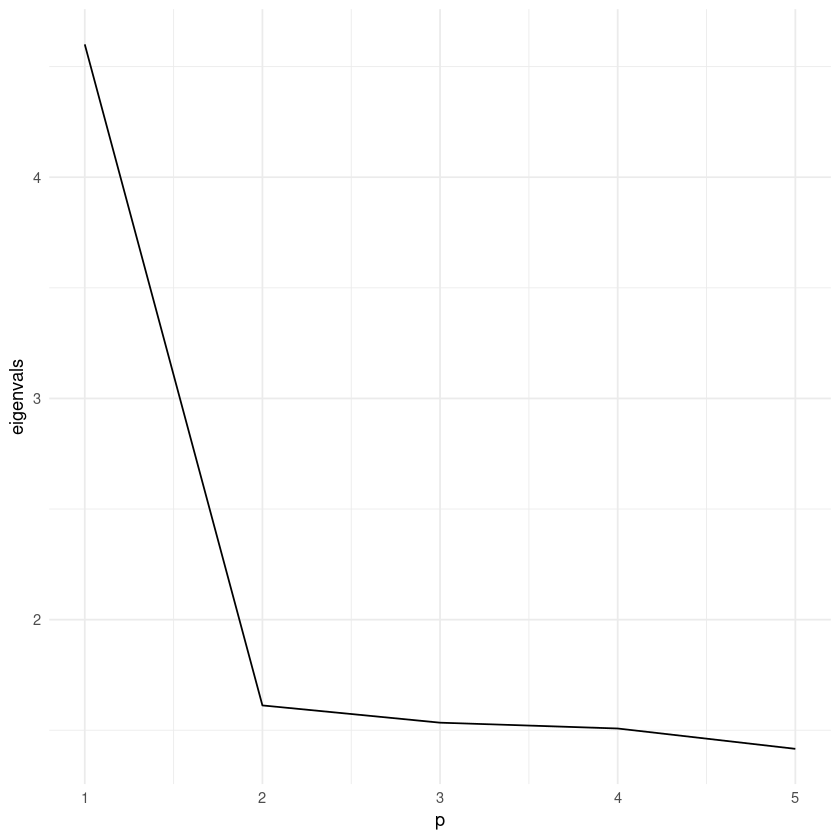

In [62]:
screeplotdat3 <- data.frame(p = 1:5, eigenvals = specdecomp3$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat3) + 
geom_line() + 
theme_minimal()

# PCA by Cooley and Thibaud 

In [63]:
# Tail pairwise dependence matrix code by Yiang 

decls <- function(x, th, k) {
    ## Ordinary decluster.
    id.big <- which(x > th)
    id.dif <- diff(id.big)
    tick <- which(id.dif >= k)
    start <- id.big[c(1, tick + 1)]              # Where a new cluster begins
    end <- c(id.big[tick], last(id.big, 1))
    n <- length(start)
    id.res <- rep(0, n)
    for ( i in 1 : n) {
        temp <- x[start[i] : end[i]]
        id.res[i] <- which(temp == max(temp, na.rm = TRUE))[1] + start[i] - 1
    }
    id.res
}

rw.Sigma <- function(X, u = 0.98, decluster = F) {
    ## Compute TPDM
    P <- ncol(X)                      # Number of stations
    M <- nrow(X)                      # Number of obs
    Sigma <- matrix(0, P, P)
    for ( i in 1 : P) {
        if (i %% 5 == 0) print(i)
        for ( j in 1 : P) {
            r <- sqrt(X[, i] ^ 2 + X[, j] ^ 2)
            w1 <- X[, i] / r
            w2 <- X[, j] / r
            th <- quantile(r, u, na.rm = TRUE)
            if(decluster) {
                id <- decls(r, th, 5)
            } else {
                id <- which(r > th)
            } 
            Sigma[i, j] <- sum(w1[id] * w2[id], na.rm = TRUE) / (length(id)) * 2
        }
    }
    Sigma
}

ecdf_shifted <- function(z) length(z) / (length(z) + 1) * ecdf(z)(z) + 1 / (length(z) + 1)

##applies the transformation t
trans <- function(x)
{
    ##because it takes an exponential, this function flakes out if x is too big
    ##hence for big values of x, we return x
    v <- log(1 + exp(x))
    id <- which(x < -20)
    v[!is.finite(v)] <- x[!is.finite(v)]
    v[id] <- exp(x[id])
    return(v)
}

##applies the inverse transformation t^{-1}
invTrans <- function(v)
{
    ##same trickeration for big values of v
    ##still returns -Inf if v is machine zero
    x <- log(exp(v) - 1)
    x[!is.finite(x) & v > 1 & !is.na(x)] <- v[!is.finite(x) & v > 1 &
                                                  !is.na(x)]

    return(x)
}

In [64]:
# use a multiplicatively rescaled estimator to ensure that the ecdf does not take the values 0 and 1.
ecdf_shifted <- function(z) length(z) / (length(z) + 1) * ecdf(z)(z)

In [65]:
# Transform data to approximately 2-Fréchet margins 
X1trafo_2frech <- apply(X1trafo, 2, function(z) 1 / sqrt(-log(ecdf_shifted(z))))
X2trafo_2frech <- apply(X2trafo, 2, function(z) 1 / sqrt(-log(ecdf_shifted(z))))
X3trafo_2frech <- apply(X3trafo, 2, function(z) 1 / sqrt(-log(ecdf_shifted(z))))

In [66]:
X1sphere <- t(apply(X1trafo_2frech, 1, function(z) z / sqrt(sum(z^2))))
X2sphere <- t(apply(X2trafo_2frech, 1, function(z) z / sqrt(sum(z^2))))
X3sphere <- t(apply(X3trafo_2frech, 1, function(z) z / sqrt(sum(z^2))))

rownorms1 <- apply(X1trafo_2frech, 1, function(z) sqrt(sum(z^2)))
rownorms2 <- apply(X2trafo_2frech, 1, function(z) sqrt(sum(z^2)))
rownorms3 <- apply(X3trafo_2frech, 1, function(z) sqrt(sum(z^2)))


# for t = 15 we have the same number of observations exceeding the threshold as for the other procedure
X1sphere_extr <- X1sphere[which(rownorms1 > 15), ]
X2sphere_extr <- X2sphere[which(rownorms2 > 15), ]
X3sphere_extr <- X3sphere[which(rownorms3 > 15), ]

tpdm1 <- t(X1sphere_extr) %*% X1sphere_extr / 117
tpdm2 <- t(X2sphere_extr) %*% X2sphere_extr / 117
tpdm3 <- t(X3sphere_extr) %*% X3sphere_extr / 117

In [67]:
specdecomp1_cy <- eigen(tpdm1)
specdecomp2_cy <- eigen(tpdm2)
specdecomp3_cy <- eigen(tpdm3)

In [83]:
specdecomp1_cy

eigen() decomposition
$values
[1] 1.877650424 0.008651357 0.007609438 0.006409445 0.005662242

$vectors
          [,1]         [,2]        [,3]        [,4]       [,5]
[1,] 0.4484271 -0.849648002  0.08246908  0.16015698 -0.2110923
[2,] 0.4468783 -0.007512392 -0.15792528 -0.05117444  0.8790245
[3,] 0.4473453  0.426701701  0.03245545  0.76596595 -0.1733512
[4,] 0.4466900  0.183615044 -0.67376694 -0.41856721 -0.3709355
[5,] 0.4467249  0.249505533  0.71640995 -0.45807049 -0.1229312


In [84]:
specdecomp2_cy

eigen() decomposition
$values
[1] 1.67152512 0.07601831 0.06722914 0.05474246 0.04501488

$vectors
          [,1]       [,2]        [,3]       [,4]        [,5]
[1,] 0.4521064  0.3666333  0.61344816  0.5318686  0.04446312
[2,] 0.4453278  0.1485808  0.09365347 -0.5305004 -0.69957507
[3,] 0.4429758  0.1047665  0.02227363 -0.5339876  0.71214996
[4,] 0.4428638 -0.8789212  0.05645021  0.1662551 -0.02327542
[5,] 0.4526887  0.2450004 -0.78181049  0.3505733 -0.03030600


In [85]:
specdecomp3_cy

eigen() decomposition
$values
[1] 1.2221421 0.2021462 0.1813574 0.1709525 0.1635727

$vectors
          [,1]        [,2]        [,3]       [,4]        [,5]
[1,] 0.4515348  0.19393748  0.67750204 -0.5468743 -0.02059118
[2,] 0.4571541  0.63977919 -0.16655010  0.3807963  0.45710824
[3,] 0.4432328 -0.06820440 -0.70419591 -0.5243165 -0.16761029
[4,] 0.4393894 -0.04853425  0.09388737  0.4899585 -0.74545775
[5,] 0.4445313 -0.73896105  0.09244094  0.2023747  0.45478302


In [68]:
if(specdecomp1_cy$vectors[1,1] < 0) specdecomp1_cy$vectors[,1] <- -specdecomp1_cy$vectors[,1]
if(specdecomp2_cy$vectors[1,1] < 0) specdecomp2_cy$vectors[,1] <- -specdecomp2_cy$vectors[,1]
if(specdecomp3_cy$vectors[1,1] < 0) specdecomp3_cy$vectors[,1] <- -specdecomp3_cy$vectors[,1]

Saving 6.67 x 6.67 in image


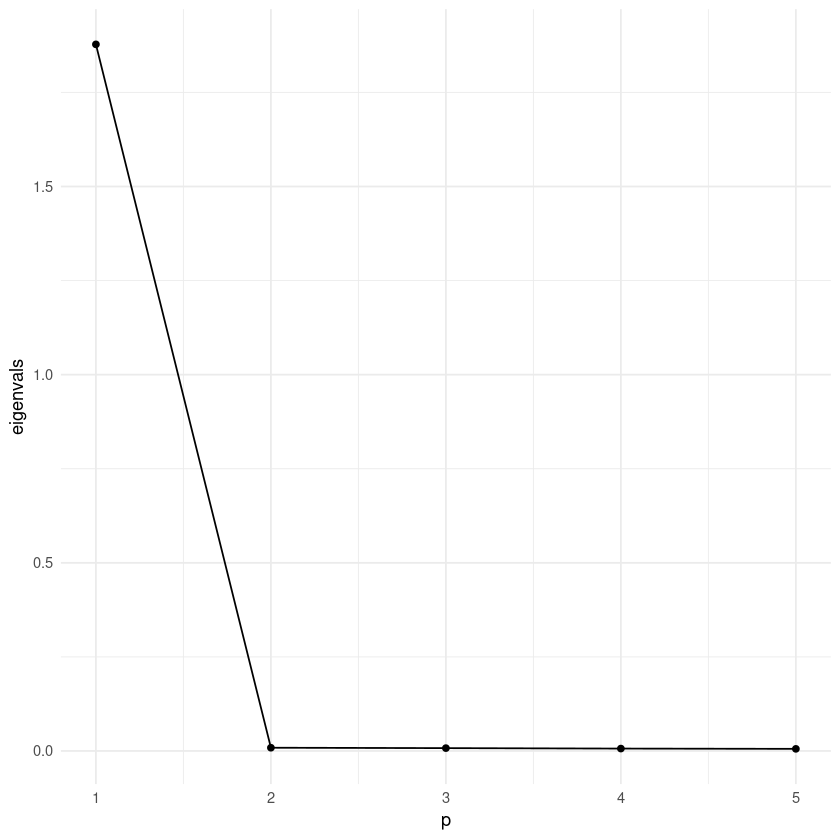

In [69]:
elbow_dat1_cy <- data.frame(p = 1:5, eigenvals = specdecomp1_cy$values)
elbow1_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat1_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_log1.pdf", elbow1_cy)
elbow1_cy

Saving 6.67 x 6.67 in image


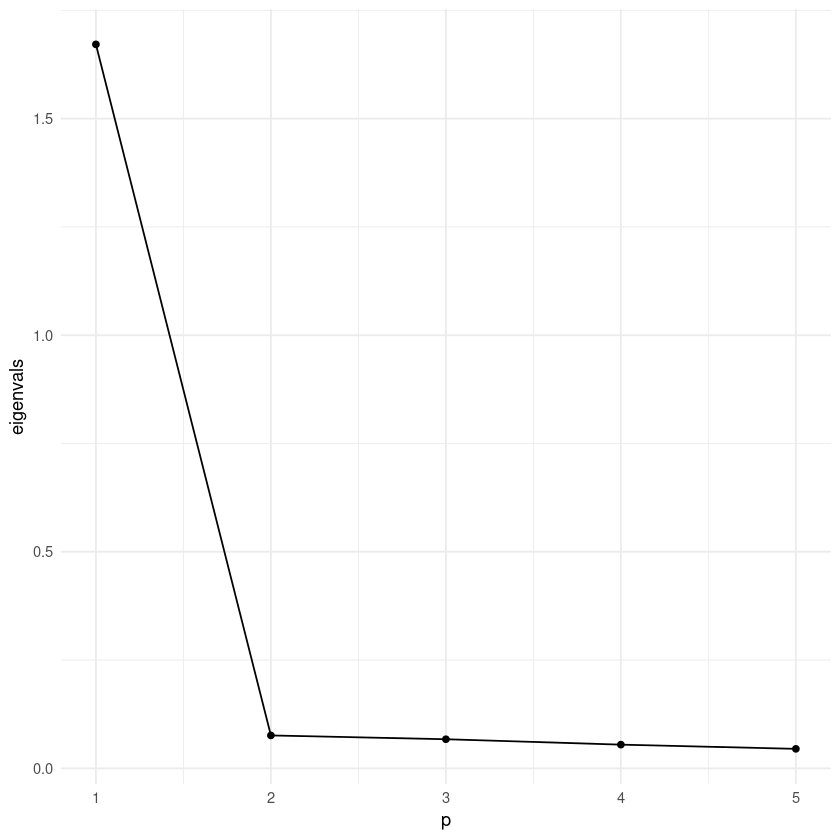

In [70]:
elbow_dat2_cy <- data.frame(p = 1:5, eigenvals = specdecomp2_cy$values)
elbow2_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat2_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_log2.pdf", elbow2_cy)
elbow2_cy

Saving 6.67 x 6.67 in image


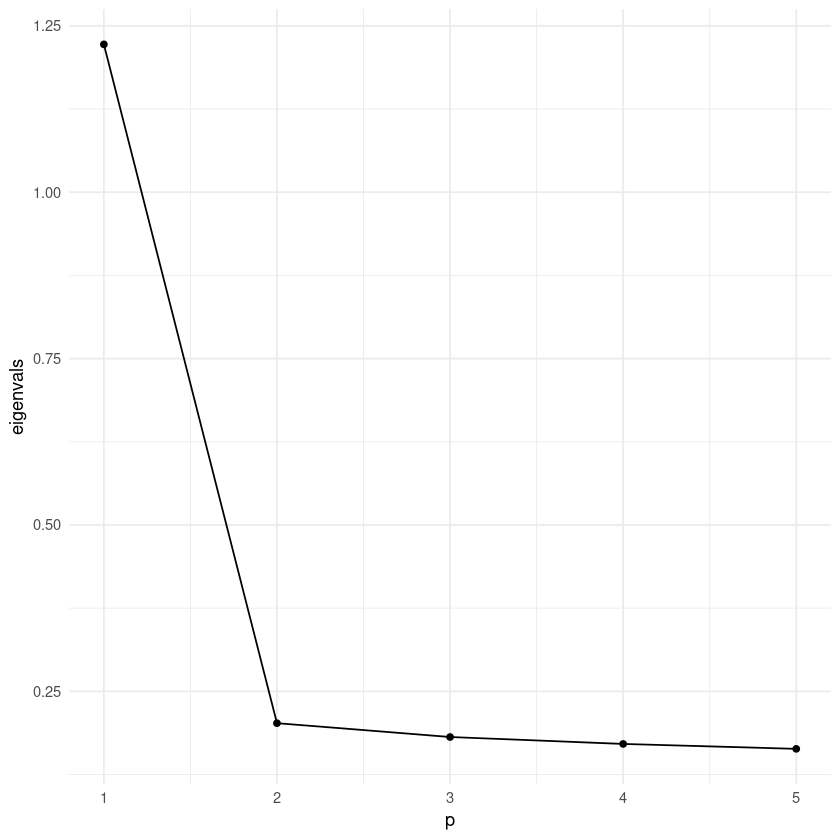

In [71]:
elbow_dat3_cy <- data.frame(p = 1:5, eigenvals = specdecomp3_cy$values)
elbow3_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat3_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_log3.pdf", elbow3_cy)
elbow3_cy

In [72]:
enc1_cy <- t(specdecomp1_cy$vectors[, 1:3]) %*% t(invTrans(X1trafo_2frech))
rec1_cy <- t(specdecomp1_cy$vectors[, 1:3] %*% trans(enc1_cy))

enc2_cy <- t(specdecomp2_cy$vectors[, 1:3]) %*% t(invTrans(X2trafo_2frech))
rec2_cy <- t(specdecomp2_cy$vectors[, 1:3] %*% trans(enc2_cy))

enc3_cy <- t(specdecomp3_cy$vectors[, 1:3]) %*% t(invTrans(X3trafo_2frech))
rec3_cy <- t(specdecomp3_cy$vectors[, 1:3] %*% trans(enc3_cy))

Joining with `by = join_by(X1, X2, X3, X4, X5)`


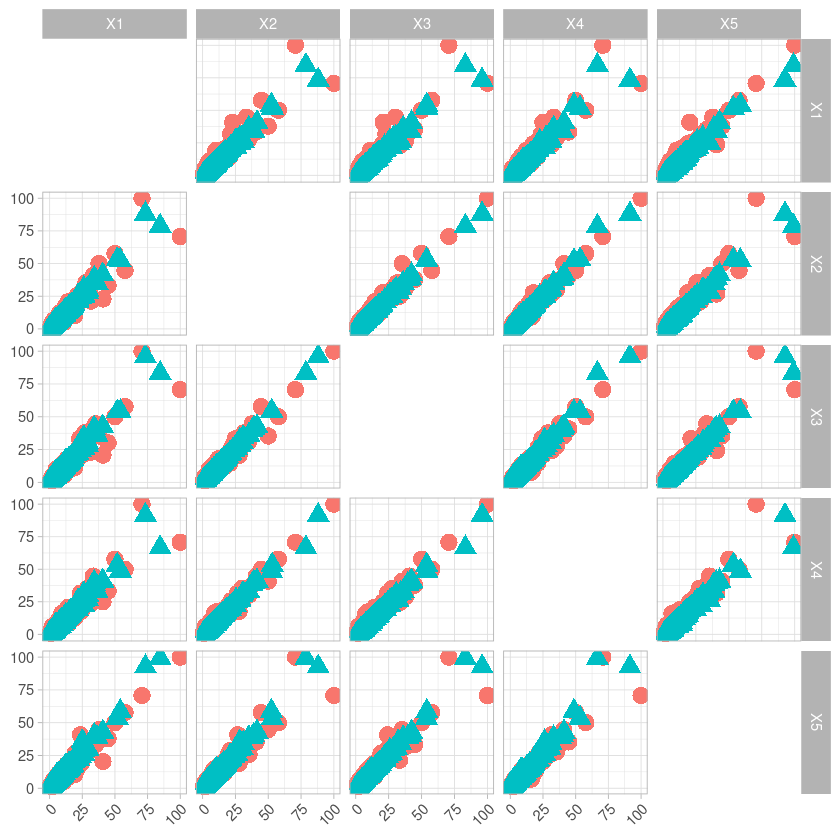

In [73]:
plot_dat1 <- data.frame(X1trafo_2frech)
tmp <- data.frame(rec1_cy)
plot_dat1 <- full_join(plot_dat1, tmp)
plot_dat1$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat1,    
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Joining with `by = join_by(X1, X2, X3, X4, X5)`


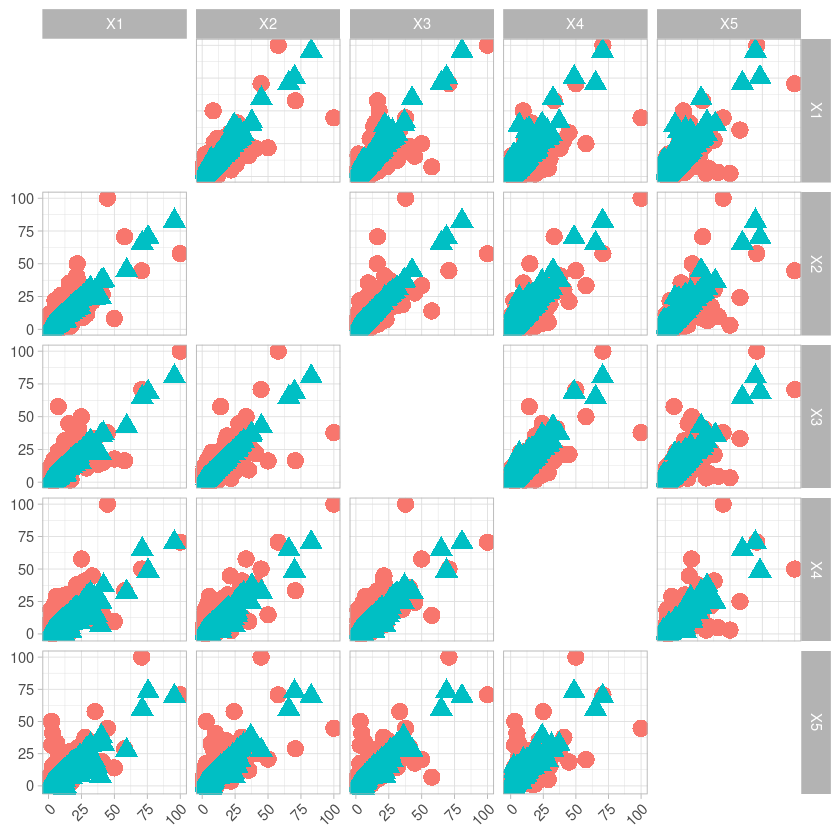

In [74]:
plot_dat2 <- data.frame(X2trafo_2frech)
tmp <- data.frame(rec2_cy)
plot_dat2 <- full_join(plot_dat2, tmp)
plot_dat2$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat2,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Joining with `by = join_by(X1, X2, X3, X4, X5)`


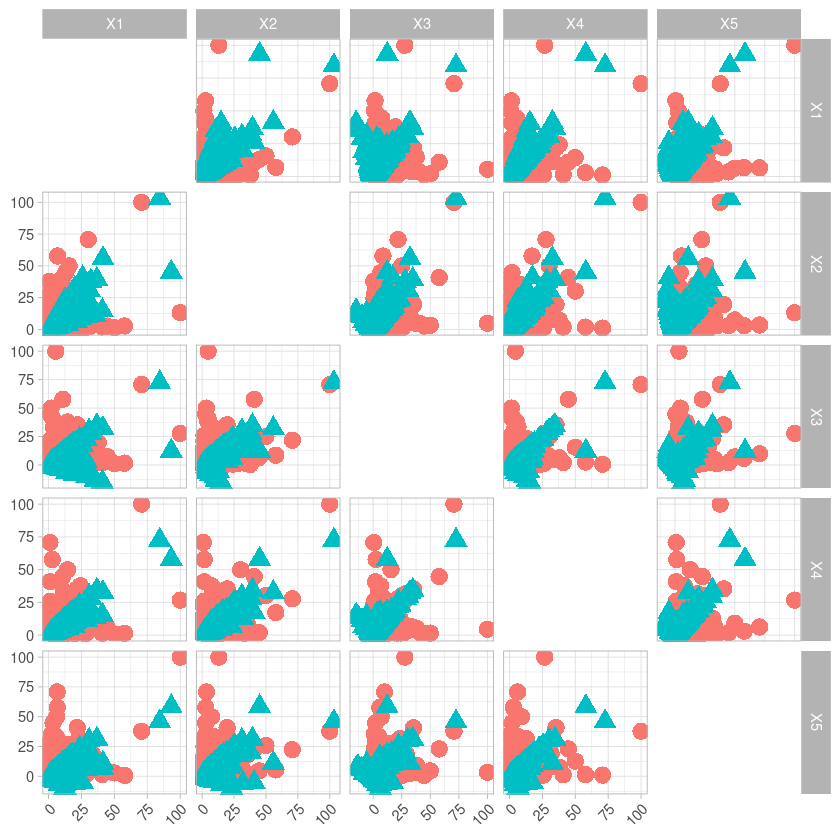

In [75]:
plot_dat3 <- data.frame(X3trafo_2frech)
tmp <- data.frame(rec3_cy)
plot_dat3 <- full_join(plot_dat3, tmp)
plot_dat3$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat3,    
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

# Spherical K-means

In [76]:
library(skmeans)

In [77]:
kmeanserrs1 = data.frame(k = 1:5, errs = NA)
kmeansclusterings1 = list()
for(k in 2:5) {
    tmp <- skmeans::skmeans(X1trafo[which(rowSums(X1trafo) > 250), ], k = k)
    kmeansclusterings1[[k]] <- tmp
    kmeanserrs1[k,2] <- tmp$value
}

In [78]:
kmeanserrs2 = data.frame(k = 1:5, errs = NA)
kmeansclusterings2 = list()
for(k in 2:5) {
    tmp <- skmeans::skmeans(X2trafo[which(rowSums(X2trafo) > 250), ], k = k)
    kmeansclusterings2[[k]] <- tmp
    kmeanserrs2[k,2] <- tmp$value
}

In [79]:
kmeanserrs3 = data.frame(k = 1:5, errs = NA)
kmeansclusterings3 = list()
for(k in 2:5) {
    tmp <- skmeans::skmeans(X3trafo[which(rowSums(X3trafo) > 250), ], k = k)
    kmeansclusterings3[[k]] <- tmp
    kmeanserrs3[k,2] <- tmp$value
}

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


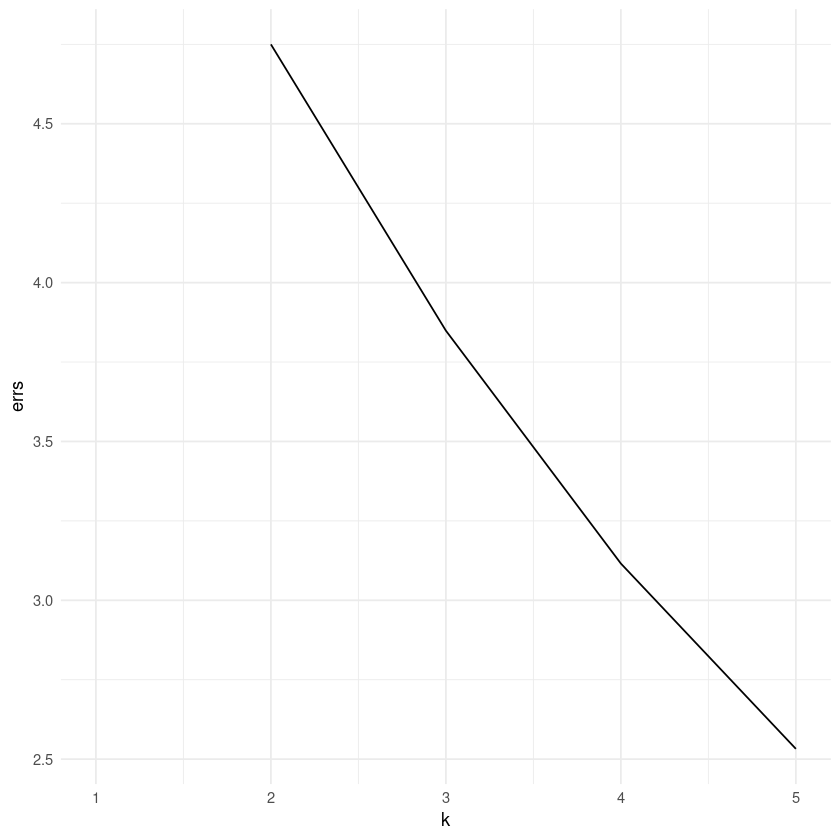

In [80]:
ggplot(aes(x = k, y = errs), data = kmeanserrs1) + 
geom_line() +
theme_minimal()

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


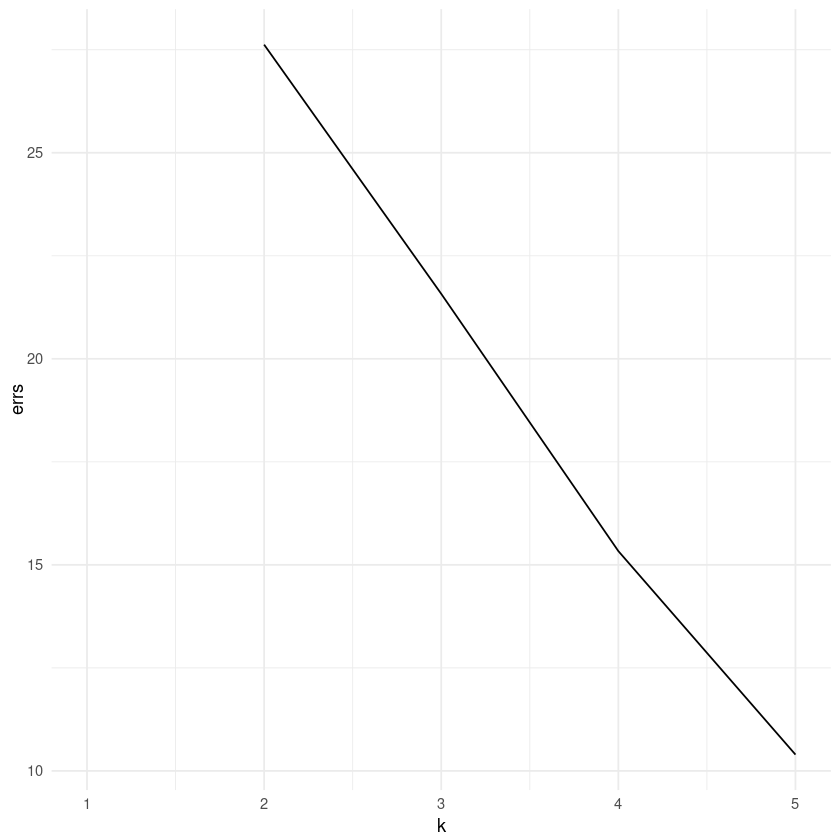

In [81]:
ggplot(aes(x = k, y = errs), data = kmeanserrs2) + 
geom_line() +
theme_minimal()

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


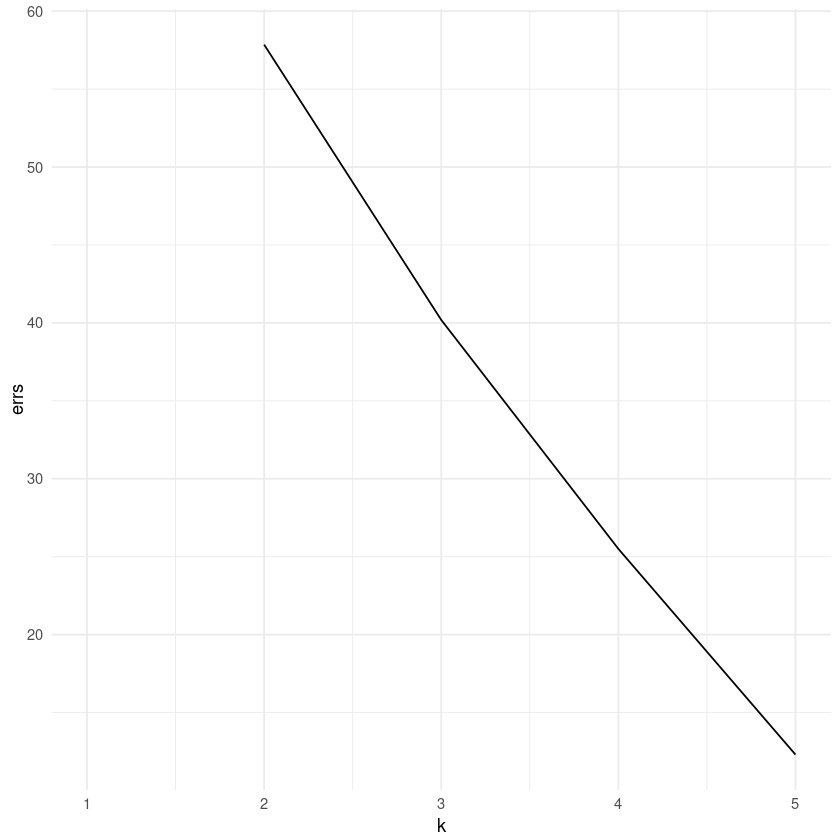

In [82]:
ggplot(aes(x = k, y = errs), data = kmeanserrs3) + 
geom_line() +
theme_minimal()